In [6]:
# Preprocessors
import copy
import os

import cv2

from preprocessing.Preprocessors import *
from preprocessing.Paint_Extractor_Preprocessor import *
from preprocessing.Noise_Extractor_Preprocessor import *
from preprocessing.Color_Preprocessor import *
from preprocessing.Text_Extractor_Preprocessor import *

# Descriptors
from descriptors.Color_Descriptors import *
from descriptors.Text_Descriptors import *
from descriptors.Texture_Descriptors import *
from descriptors.Local_Descriptors import *

#CORE
from core.CoreImage import *

#Utils
from utils import utils
from utils.distance_metrics import *

import textdistance


## Auxiliar imports
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import  matplotlib.pyplot as plt

In [138]:
def extract(image):
    if utils.estimate_noise(image) > 1:
        image = utils.denoise(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    comb = utils.scharr_filter(gray, True)
    
    kernel = np.ones((3,1))
    binary = cv2.medianBlur(cv2.morphologyEx(comb, cv2.MORPH_OPEN, kernel), 7)
    binary = (binary[:,:,None]).mean(axis=2)    
    
    img_fourier = np.fft.fftshift(np.fft.fft2(binary))
    mag_ff = np.log(abs(img_fourier))
    binary_img = copy.copy(img_fourier)
    
    ## horitzontal filter pass
    center_coordinates = (mag_ff.shape[1]//2, mag_ff.shape[0]//2)

    axes_length = (int(mag_ff.shape[1] * 0.05), int(mag_ff.shape[0] * 0.05))

    mask_image  = np.zeros_like(mag_ff).copy()


    horitzontal_elipsis = cv2.ellipse(mask_image, center_coordinates, axes_length, 0, 0, 360, (255,255) , -1)
    
    
    ## vertical filter band
    center_coordinates = (mag_ff.shape[1]//2, mag_ff.shape[0]//2)

    axes_length = (int(mag_ff.shape[0] * 0.05), int(mag_ff.shape[1] * 0.05))

    mask_image  = np.zeros_like(mag_ff).copy()


    vertical_elipsis = cv2.ellipse(mask_image, center_coordinates, axes_length, 0, 0, 360, (255,255) , -1)
    
    ## apply butterfilter
    ff_h = binary_img * horitzontal_elipsis
    ff_v = binary_img * vertical_elipsis
    
    ## recover image in both directions
    img_back_h = abs(np.fft.ifft2(ff_h))
    img_back_v = abs(np.fft.ifft2(ff_v))

    
    ## intersect intensities in two directions
    merge = (img_back_v + img_back_h)/2
    
    ## threshold
    thresholded = ((merge > merge.max()//3 )*255).astype("uint8")
    
    ## dilate
    kernel = (int(thresholded.shape[1]*0.025), 1)
    final_mask =utils.apply_dilate(thresholded, kernel=kernel, iterations=5)
    
    ## Detect the mask 
    contours, hierarchy = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    decission = []
    for contour in contours:
        convexHull = cv2.convexHull(contour)

        x,y,w,h = cv2.boundingRect(convexHull)
        aspect_ratio = w/h
        area = w*h
        perimeter = cv2.arcLength(convexHull, True)


        #if w > h:
        decission.append(([y,x,h,w], area, perimeter ,aspect_ratio)) 




    decission = sorted(decission, key=lambda x: x[2], reverse=True)
    
    ## merge all bbox aligned over same axis 
    final_mask_2 = np.zeros_like(final_mask)
    ay, ax, ah, aw = decission[0][0]

    final_mask_2[ay:ay+ah, ax:ax+aw] = 1

    constrain_y = final_mask_2.shape[0]*0.01
    constrain_x = final_mask_2.shape[1]*0.2

    if len(decission) > 1:
        for idx in range(1, len(decission)):
            new_y, new_x, new_h, new_w = decission[idx][0]
            condition_w = min(abs(ax - new_x), abs(ax + aw - new_x))
            if (abs(ay - new_y) < constrain_y ) and (condition_w < constrain_x) :

                ay, ax, ah, aw = min(ay, new_y)-10, min(ax, new_x)+10, max(ah, new_h), (aw+new_w) 

                final_mask_2[ay:ay+ah, ax:ax+aw] = 1


        contours, hierarchy = cv2.findContours(final_mask_2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        plt.imshow(final_mask_2, cmap="gray")
        convexHull = cv2.convexHull(contours[0])

        x,y,w,h = cv2.boundingRect(convexHull)
        final_decission = [y,x,h,w]

    else:
        final_decission = decission[0][0]
        
    # text extraction
    reader = easyocr.Reader(['en'])
    y,x,h,w = final_decission
    
    if y -10 < 0:
        detected = gray[y:y+h+5, x:x+w]
    else:
        detected = gray[y-10:y+h+5, x:x+w]
        
    tokens = sorted(reader.readtext(detected, detail=0))
                
    
    return final_decission, tokens



def harmonize_tokens(text):
    final_text = []
    if len(text) >0:
        for t in text:
            t = t.split(" ")
            for st in t:
                ext = [c for c in st if c.isalpha()]
                ext = "".join(ext)
                if len(ext) > 0:
                    final_text.append(ext)
    final_text = " ".join(final_text)
    
    return final_text

In [139]:
def harmonize_tokens(text):
    final_text = []
    if len(text) > 0:
        for t in text:
            t = t.split(" ")
            for st in t:
                ext = [c for c in st if c.isalpha()]
                ext = "".join(ext)
                if len(ext) > 0:
                    final_text.append(ext)
    final_text = sorted(final_text)
    final_text = " ".join(final_text)

    return final_text

In [197]:
utils.read_author_bbdd("../data/BBDD")
BBDD_AUTHORS = sorted(utils.read_author_bbdd("../data/BBDD"))


In [198]:
with open(str(BBDD_AUTHORS[0]), "r") as f:
    a = (f.readline().strip().split(","))
    if len(a) != 0:
        a = a[0]
        author = (a[1:].split(",")[0]).split(" ")
        print(author)
        harmo_authors = harmonize_tokens(author)
        
    else:
        harmo_authors = "Unkown"

["'Victor", "Perez-Porros'"]


In [199]:
queries = utils.read_pickle("../data/qst1_w4/qst1_w4_processed.pkl")

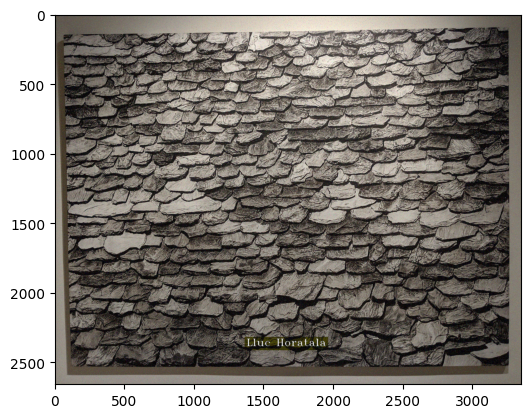

In [614]:
plt.imshow(queries[11].image)
quadre = queries[11].image

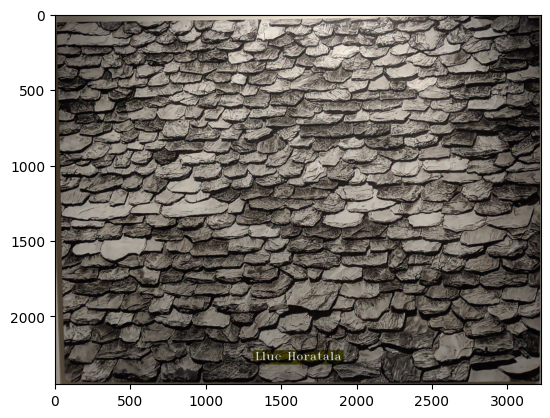

In [615]:
idx = 11
plt.imshow(queries[idx][0]._paint)
paint = queries[idx][0]._paint


In [616]:
#paint = copy.copy(quadre)

In [617]:
#if utils.estimate_noise(paint) > 1:
 #   image_test = utils.denoise(paint)
gray = cv2.cvtColor(paint, cv2.COLOR_BGR2GRAY)

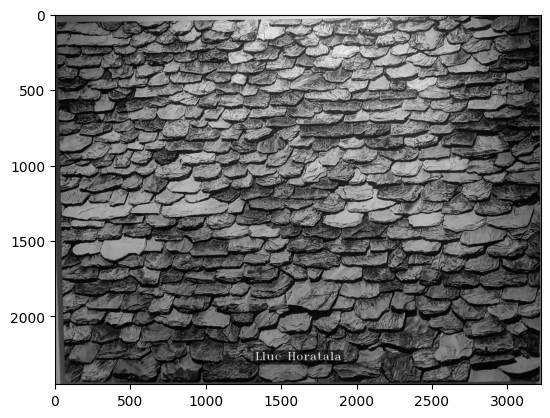

In [618]:
plt.imshow(gray, cmap="gray")

In [619]:
comb = utils.scharr_filter(gray, True)

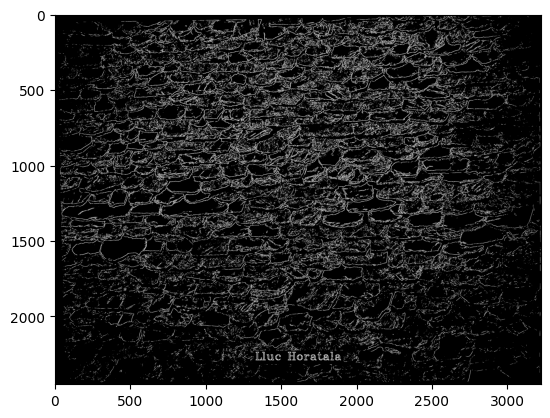

In [620]:
plt.imshow(comb, cmap="gray")

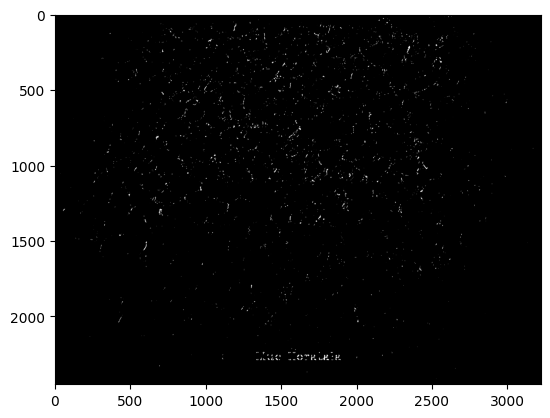

In [621]:
kernel = np.ones((3,1))
binary = cv2.medianBlur(cv2.morphologyEx(comb, cv2.MORPH_OPEN, kernel), 7)
binary = (binary[:,:,None]).mean(axis=2)
plt.imshow((binary), cmap="gray")

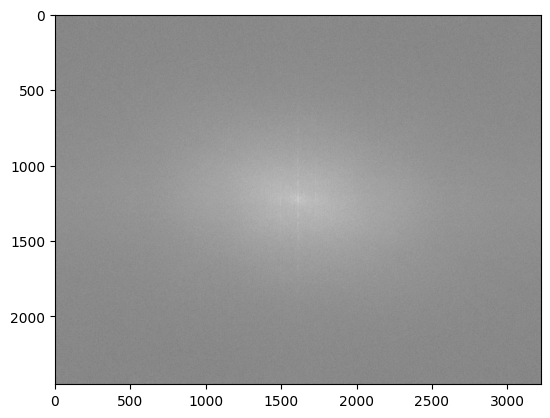

In [622]:
img_fourier = np.fft.fftshift(np.fft.fft2(binary))
mag_ff = np.log(abs(img_fourier))
plt.imshow(mag_ff, cmap="gray")

In [623]:
binary_img = copy.copy(img_fourier)

In [624]:
center_coordinates = (mag_ff.shape[1]//2, mag_ff.shape[0]//2)

axes_length = (int(mag_ff.shape[1] * 0.01), int(mag_ff.shape[0] * 0.01))

image  = np.zeros_like(mag_ff).copy()


horitzontal_elipsis = cv2.ellipse(image, center_coordinates, axes_length, 0, 0, 360, (255,255) , -1)

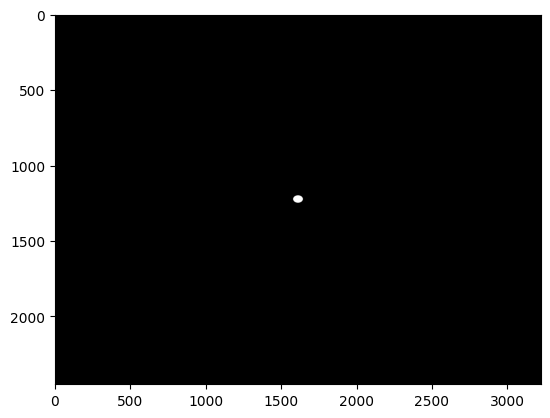

In [625]:
plt.imshow(horitzontal_elipsis, cmap="gray")

In [626]:
mag_h = mag_ff * horitzontal_elipsis

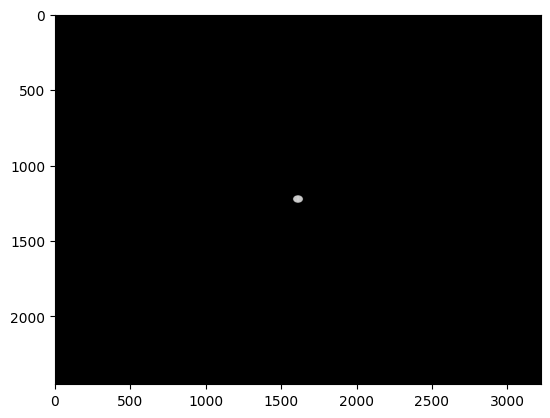

In [627]:
plt.imshow(mag_h, cmap="gray")

In [628]:
center_coordinates = (mag_ff.shape[1]//2, mag_ff.shape[0]//2)

axes_length = (int(mag_ff.shape[0] * 0.01), int(mag_ff.shape[1] * 0.01))

image  = np.zeros_like(mag_ff).copy()


vertical_elipsis = cv2.ellipse(image, center_coordinates, axes_length, 0, 0, 360, (255,255) , -1)

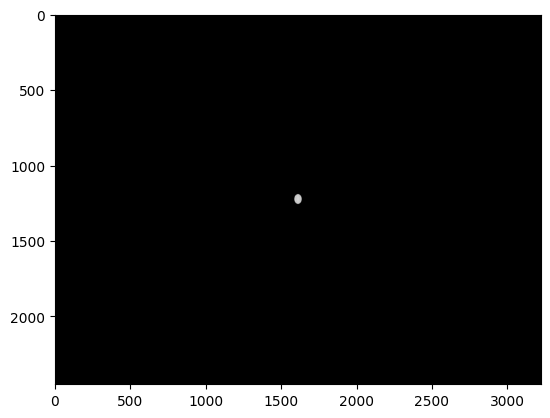

In [629]:
mag_v = mag_ff * vertical_elipsis
plt.imshow(mag_v, cmap="gray")


In [630]:
ff_h = binary_img * horitzontal_elipsis
ff_v = binary_img * vertical_elipsis

In [631]:
img_back_h = abs(np.fft.ifft2(ff_h))
img_back_v = abs(np.fft.ifft2(ff_v))



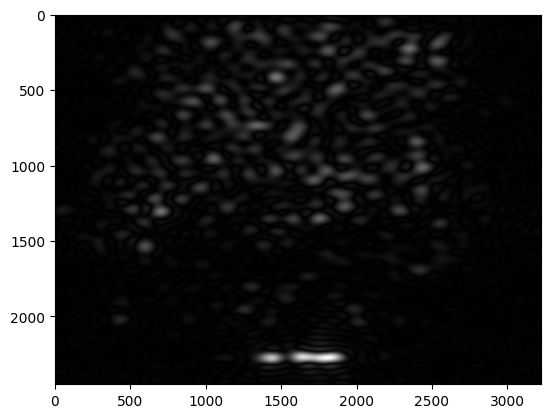

In [632]:
plt.imshow(img_back_v, cmap="gray")

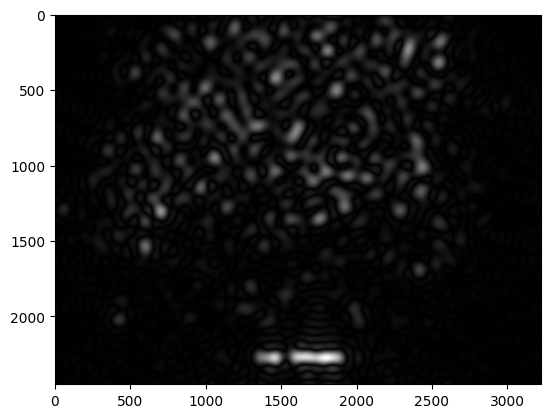

In [633]:
plt.imshow(img_back_h, cmap="gray")


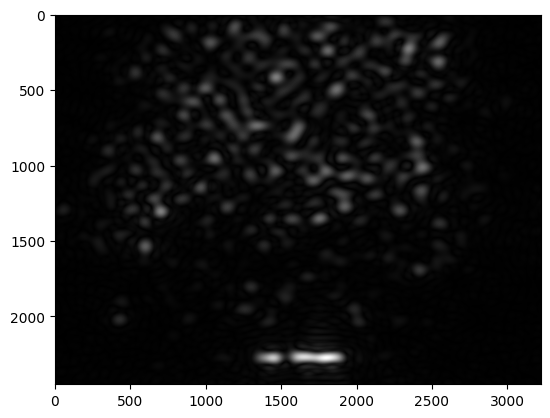

In [634]:
merge = (img_back_v + img_back_h)/2
plt.imshow(merge, cmap="gray")

In [635]:
thresholded = ((merge > merge.max()//3 )*255).astype("uint8")

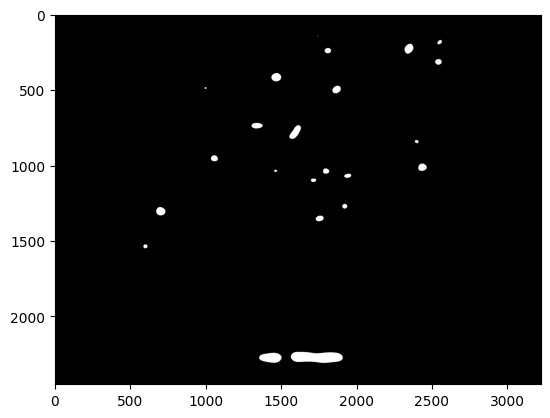

In [636]:
plt.imshow(thresholded, cmap="gray")

In [637]:
kernel = (int(thresholded.shape[1]*0.025), 1)

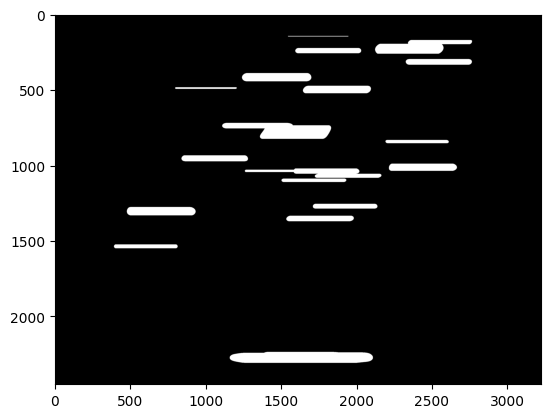

In [638]:
plt.imshow(utils.apply_dilate(thresholded, kernel=kernel, iterations=5) , cmap="gray")

In [639]:
final_mask = utils.apply_dilate(thresholded, kernel=kernel, iterations=5)

In [640]:
## Detect the mask 
contours, hierarchy = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
decission = []
for contour in contours:
    convexHull = cv2.convexHull(contour)

    x,y,w,h = cv2.boundingRect(convexHull)
    aspect_ratio = w/h
    area = w*h
    perimeter = cv2.arcLength(convexHull, True)


    #if w > h:

    decission.append(([y,x,h,w], area, perimeter ,aspect_ratio)) 



print(decission)
decission = sorted(decission, key=lambda x: x[2], reverse=True)
print(decission)

## merge all bbox aligned over same axis 
final_mask_2 = np.zeros_like(final_mask)
ay, ax, ah, aw = decission[0][0]

final_mask_2[ay:ay+ah, ax:ax+aw] = 1

constrain_y = final_mask_2.shape[0]*0.01
constrain_x = final_mask_2.shape[1]*0.2


[([2238, 1158, 73, 949], 69277, 1951.157603263855, 13.0), ([1526, 390, 26, 423], 10998, 873.3508821725845, 16.26923076923077), ([1336, 1533, 37, 448], 16576, 931.0900130271912, 12.108108108108109), ([1278, 476, 56, 456], 25536, 972.58919942379, 8.142857142857142), ([1257, 1709, 32, 428], 13696, 889.9108482599258, 13.375), ([1090, 1501, 23, 430], 9890, 881.5700367689133, 18.695652173913043), ([1023, 1258, 62, 906], 56172, 1836.4774998426437, 14.612903225806452), ([991, 2213, 48, 451], 21648, 954.1677148342133, 9.395833333333334), ([936, 838, 40, 441], 17640, 924.0178065299988, 11.025), ([834, 2190, 22, 420], 9240, 860.9065937995911, 19.09090909090909), ([721, 1108, 106, 722], 76532, 1521.7595727443695, 6.811320754716981), ([485, 796, 11, 409], 4499, 827.5984033346176, 37.18181818181818), ([475, 1643, 50, 451], 22550, 954.3057413101196, 9.02), ([391, 1239, 55, 460], 25300, 977.1839742660522, 8.363636363636363), ([298, 2324, 38, 439], 16682, 916.0815505981445, 11.552631578947368), ([225, 

In [399]:
(queries[7][0]._text)

['CJ DUJ L', 'Duran Pep', 'D GL L UJ', 'Duran Pep']

['Agut Pep', 'Agut Il Pep T', 'Agut Pep', 'Agut L Pep T']


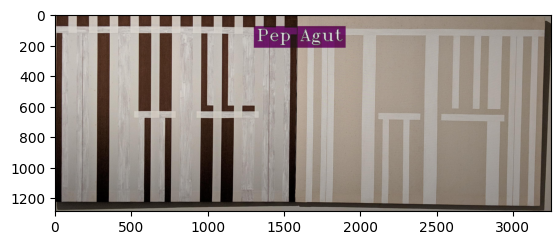

In [409]:
plt.imshow(queries[9][0]._paint)
print(queries[9][0]._text)

In [286]:
authors_BBDD = utils.read_pickle("../data/BBDD/authors.pkl")
authors_BBDD

{'PerezPorros Victor': [0, 134],
 'Demarco Hugo': [1],
 'Unknown': [2,
  9,
  14,
  17,
  18,
  19,
  29,
  33,
  36,
  38,
  49,
  56,
  59,
  61,
  62,
  65,
  66,
  73,
  80,
  85,
  97,
  98,
  105,
  108,
  112,
  114,
  115,
  125,
  126,
  127,
  129,
  138,
  139,
  141,
  144,
  145,
  148,
  152,
  153,
  156,
  159,
  171,
  185,
  186,
  189,
  191,
  195,
  196,
  197,
  205,
  208,
  209,
  213,
  229,
  230,
  253,
  255,
  264,
  268,
  269,
  270,
  278,
  279,
  284],
 'Edvard Munch': [3, 63, 69, 84, 94, 132, 135, 232, 234, 237, 271, 275],
 'Carral Martin': [4, 188],
 'Mario Pasqualotto': [5, 99],
 'Gerard Sala': [6],
 'Hortal Yago': [7],
 'Guinovart Josep': [8, 25, 242],
 'Agusti Puig': [10, 37, 121, 180, 216],
 'Hernandez Joan Pijuan': [11, 93, 190, 207, 238, 280, 285],
 'Gimenez Regina': [12, 200],
 'Pere Santilari': [13, 52, 77, 277],
 'Ginovart Josep': [15],
 'Corneille': [16],
 'Antoni Llena': [20, 204, 236],
 'Cisquella Josep': [21],
 'Cuixart Modest': [22, 92,

In [641]:
comparer_text = queries[11][0]._text

In [642]:
comparer_text

['', 'Horatala Lluc', '', 'Horatala Lluc']

In [297]:
decission = []
for possible_auth in set(comparer_text):
    for idx, author in enumerate(authors_BBDD.keys()):
        similarity = textdistance.jaccard(possible_auth, author)
        simliarity = similarity
        
        if similarity > 0.7:
            decission.append((idx, similarity))

decission = sorted(decission, key=lambda x: x[1], reverse=True)

In [298]:
decission

[(8, 1), (13, 0.9333333333333333)]

In [299]:
final_decission = decission[:len(comparer_text)]

In [300]:
final_decission

[(8, 1), (13, 0.9333333333333333)]

In [303]:
list(authors_BBDD.items())[8]

('Guinovart Josep', [8, 25, 242])

In [304]:
list(authors_BBDD.items())[13]


('Ginovart Josep', [15])

In [219]:
paint = queries[15][0]._paint

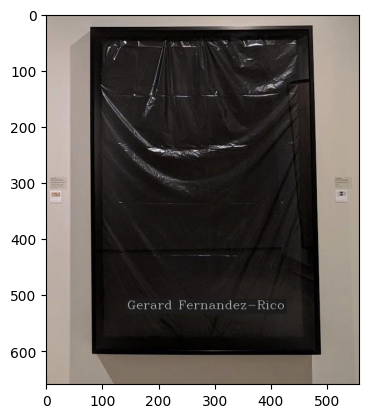

In [220]:
y,x,h,w = (refine_mask(paint)[0])

if not y == x == h == w:
    plt.imshow(paint[y:y+h,x:x+w])
else:
    plt.imshow(paint)


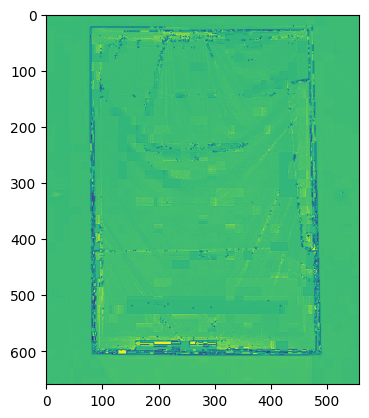

In [221]:
rg_chrom = Color_Preprocessor.convert2rg_chromaticity(paint)
enhanced = ((rg_chrom + utils.sharpening(rg_chrom)) * 255).astype("uint8")
enhanced = (enhanced[:, :, 0] + enhanced[:, :, 1]) // 2
plt.imshow(enhanced)

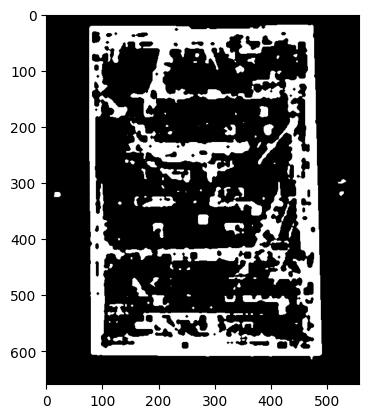

In [222]:
## applying the derivates (sobel)
edge = utils.Sobel_magnitude(enhanced, x_importance=6, y_importance=6)

thr = filters.threshold_otsu(edge)
edge = (edge > thr).astype(np.uint8)
edge = utils.apply_closing(edge, (5,5))
edge = cv2.medianBlur(edge, 5)
#edge = utils.apply_erode(edge, (3,3))
plt.imshow(edge, cmap="gray")

In [223]:
## Apply hough transform
mask = np.zeros_like(edge)
min_shape = min(edge.shape[0], edge.shape[1])
max_line_gap = int(min_shape * 0.02)
h_, w_ = edge.shape
votes_min_l = int(min(h_ * 0.05, w_ * 0.05))

linesP = cv2.HoughLinesP(edge, 1, np.pi / 180, votes_min_l, minLineLength=votes_min_l, maxLineGap=max_line_gap)

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(mask, (l[0], l[1]), (l[2], l[3]), 255, 3, cv2.LINE_AA)



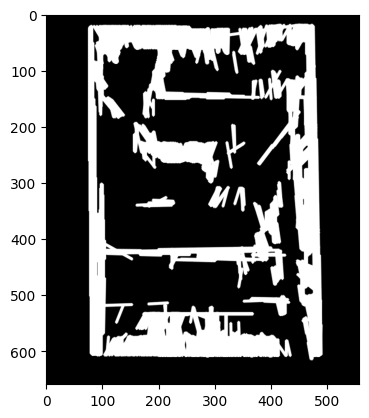

In [224]:
plt.imshow(mask, cmap="gray")

In [225]:
# Getting the contour
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
decission = []
heigh_im, width_im = edge.shape


## Getting the final bbox
new_mask = np.zeros_like(edge)
absolut_area = new_mask.shape[0] * new_mask.shape[1]

for contour in contours:
    convexHull = cv2.convexHull(contour)

    perimeter = cv2.arcLength(convexHull, True)
    x, y, w, h = cv2.boundingRect(convexHull)
    aspect_ratio = w / h
    area = w * h
    proportion_height = h / heigh_im
    proportion_width = w / width_im

    if (proportion_height > 0.15) and (proportion_width > 0.15) and width_im and (area > absolut_area * 0.7):
        decission.append(([y, x, h, w], perimeter, area, aspect_ratio))

decission = sorted(decission, key=lambda x: x[2], reverse=True)
decission = utils.non_maximun_supression(decission)

if len(decission) != 0:
    new_bbox = decission[0][0]
    y, x, h, w = new_bbox
    new_mask[y:y + h, x:x + w] = 1

else:
    new_bbox = [0,0,0,0]
    new_mask = np.ones_like(new_mask)

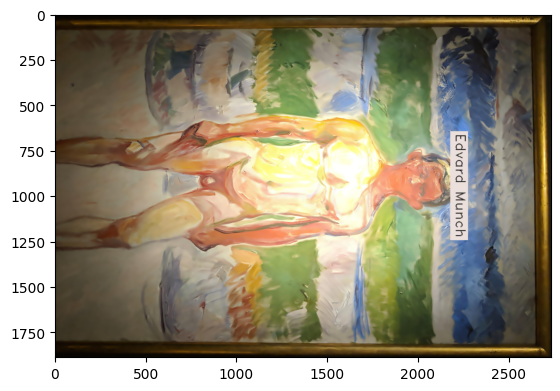

In [164]:
plt.imshow(paint[y:y+h,x:x+w])